In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline

#We are going to generate flatmaps using the Flatmap class
# Q: where do I get the flatmaps module?
#https://github.com/LSSTDESC/NaMaster/blob/master/sandbox_validation/data/flatmaps.py -SAU
# Nord: I ran the conda install procedure, but flatmaps still does not imprt. 
#You got this work after I commited flatmaps.py to the repo, right?
import flatmaps as fm
from astropy.wcs import WCS
#adding two-point correlation function to try to make a spectrum from data
from astroML.correlation import two_point

# To generate maps in flat-sky approximation we need NaMaster (pymaster)
# To install pymaster -> conda install namaster -c conda-forge

In [2]:
# Q: where did this file come from?
# From CAMB (well from Kimmy, who generated it with CAMB), https://camb.info/readme.html -SAU

#You got this off of GitHub, right?
#I think this is the link but I can't check because this coffee shop WiFi won't let me go on GitHub:
#https://github.com/cmbant/CAMB
#-SAU

# Q: what are each of the outputs?
#    l modes, TT spectrum, EE spectrum, TE spectrum, Phi-Phi spectrup, Phi-T spectrum -SAU

# Q: What is "P?"
#    Phi? -SAU
# Nord: why are you unsure about this?
#    Because I'm not exactly sure which P you're referring to, but I THINK you're referring to the P in clPP
# Nord 2020/01/13: Are there other P's?
#    Yeah, in the filename there's a lot of mumbo-jumbo like "plikHM" and I'm not sure if the "P" is part of an abbreviation or if it's random variable names or what

# Nord 2020/01/13: where can get this data?
l, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)

In [3]:
# Generate an artificial power-spectrum (you can use a "realistic" power-spectrum from CAMB or CLASS)
# ells_input = np.arange(1,10000) # We generate 10,000 multipoles
clTT = clTTa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clEE = clEEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clTE = clTEa /((l*(l+1)/(2*np.pi))) # Simple power-law power-spectrum
clPP = clPPa / (l**4 * (2.726 * 1e6)**2) # Simple power-law power-spectrum, @vis: creates the 1D spectrum to draw from
clPT = clPTa / (l**4) # Simple power-law power-spectrum
cl_input = [clTT, clEE, clTE, clPP, clPT]
#clPP[0] = 0 #Testing setting the 0-mode to 0 to change the overall strength of the map

In [4]:
#Adding 0's for the synfast_flat function to set the amplitude for the 0-mode and 1-mode to nothing
clPP_0 = np.concatenate(([0,0],clPP))

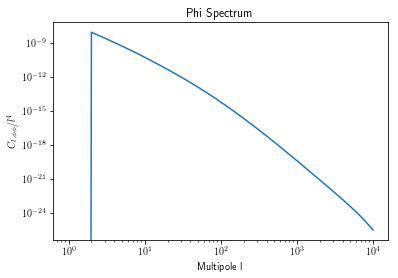

In [5]:
# Nord: what are the units on these axes? 
#X-axis is l, Y-axis I don't think has units?
#Because CAMB says the units are microK^2, and then we divide out by microK^2 when normalizing


plt.rc('text', usetex = True)
plt.plot(clPP_0)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}/l^4$")
plt.xscale("log")
plt.yscale("log")

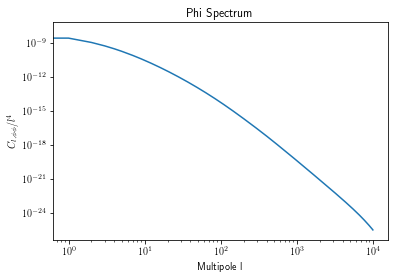

In [6]:
# Nord: what are the units on these axes? 
#X-axis is l, Y-axis I don't think has units?
#Because CAMB says the units are microK^2, and then we divide out by microK^2 when normalizing


plt.rc('text', usetex = True)
plt.plot(clPP)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}/l^4$")
plt.xscale("log")
plt.yscale("log")

In [7]:
# Create the empty map object with the resolution that we want
# Set parameters for empy map with resolution

pixels = 192.
side = 5 #5 degrees
reso = side/pixels 

reso_arcmin = 5.0/pixels*60
dx = reso_arcmin/60.0*np.pi/180.0 #reso_rad
lmax = np.pi / dx
lstep = lmax*2/pixels #SAU: why is lmax being multiplied by 2 here?

# Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = int(pixels) #Number of pixels in the x axis
ny = int(pixels) #Number of pixels in the y axis
# Q: should this be equal to pixels?
# SAU: yes, fixed

# 
w.wcs.crpix = [nx/2, ny/2] # Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] # Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] # Airy projection



In [8]:
nx
# Nord 2020/01/13: why is nx = 192, if pixels= 128 above?
# Because I hadn't rerun it since making the change -SAU

192

In [9]:
# This is the map object that will be used to generate the fake CMB maps
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) 

In [10]:
# Q: What is the math related to this?
#SAU: I don't know, I can look into it though
phi_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP_0],[0], seed = 0)

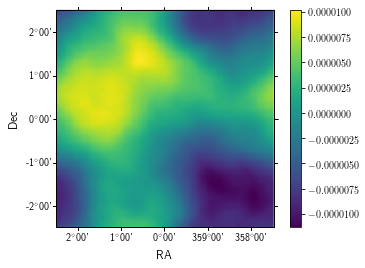

In [11]:
fmi.view_map(phi_map[0].flatten()) 

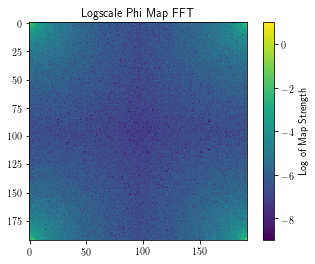

In [12]:
#This needs to be an rfft for the actual analysis and a complex fft for estimating spectra
phi_map_fft = np.fft.fft2(phi_map[0])

minimum = np.amin(abs(phi_map_fft))
maximum = np.amax(abs(phi_map_fft))

plt.imshow(np.log10(np.abs(phi_map_fft)), vmin=-9, vmax=1)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale Phi Map FFT")

np.save("phi_map_fft_0-mode", phi_map_fft)

In [13]:
#Taking the conjugate of the phi map fft
phi_map_fft_conj = np.conj(phi_map_fft)

In [14]:
#Generating the 2D Map Power
map_power_2D = phi_map_fft*phi_map_fft_conj

Text(0.5,1,'Logscale 2D Power Map')

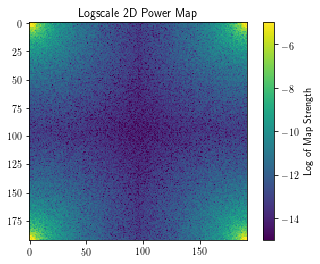

In [15]:
#Plotting 2D Map power
plt.imshow(np.log10(np.abs(map_power_2D)), vmin=-15, vmax=-5)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale 2D Power Map")

In [116]:
#summing over annulus to get spectrum
bin_num = 100
peak_l = 192*72 #192 pixels with lstep = 72
spectra_est = np.zeros((bin_num+1)) #spectum estimate before averaging
spectra_est_avg_bins = np.zeros((bin_num+1)) #spectrum estimate after averaging
bin_edges = np.linspace(0,np.sqrt(2)*peak_l, bin_num+1) #realized that since we're doing sqrt of sum it'll be sqrt(2)*192*72
bin_step = bin_edges[1]
n = np.zeros((bin_num+1))

In [117]:
#"circle" checks the shape of an annulus for a given bin
circle = np.zeros((1,2))

for i, spec in enumerate(map_power_2D):
    lx_ = 72.*i #the l-mode in the x-direction
    
    for j, pwr in enumerate(map_power_2D):
        ly_ = 72.*j #the l-mode in the y-direction
        point_on_circ = np.sqrt(lx_**2+ly_**2) #overall l-mode

        left_bin_edge = np.where(bin_edges <= point_on_circ)[0][-1] #largest bin that's smaller than overall l-mode
            
        spectra_est[left_bin_edge] += map_power_2D[i,j] #adding power at coordinate (i,j) to bin
        n[left_bin_edge] += 1 #counting the number of points in the bin for averaging later
        
        #the following lines are to test shape of annulus
        if left_bin_edge == 85: #pick which bin you want to check here
            circle = np.vstack((circle,[i,j])) #saves coordinates of all points in given annulus
        
spectra_est_avg_bins = 2*spectra_est/(bin_step**2*n) #averaging out overall all points in bin
#Joao thinks I should remove bin_step but I'm not sure if the power in a given pixel is an average over all 72 modes
#represented by a pixel or if it's a sum of power from all 72 modes represented by a pixel
#Or, actually, is it 72*72 modes in a pixel since there's 72 in x and 72 in y?

/Users/samanthausman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/samanthausman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


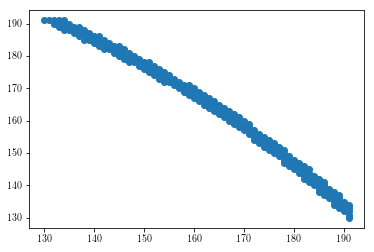

In [118]:
plt.scatter(circle[1:,0], circle[1:,1]) #plotting all points for a given annulus

Text(0,0.5,'Number of points')

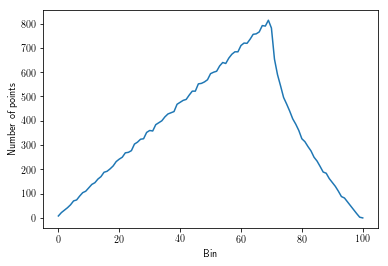

In [119]:
plt.rc('text', usetex = True)
plt.plot(n)
plt.xlabel("Bin")
plt.ylabel("Number of points")

Text(0,0.5,'$C_{l, \\phi \\phi}/l^4$')

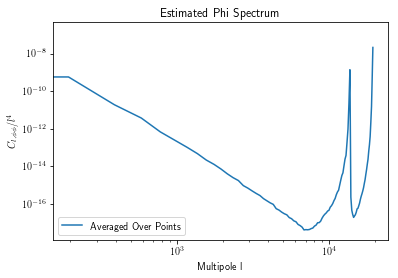

In [120]:
plt.rc('text', usetex = True)
plt.plot(bin_edges,spectra_est_avg_bins,label="Averaged Over Points")
#plt.plot(bin_edges,spectra_est_avg_ring,label="Averaged Over Ring")
plt.legend(loc="lower left")
plt.yscale("log")
plt.xscale("log")
plt.title("Estimated Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}/l^4$")

In [121]:
# Q: What is the difference between this data and the data in the previous cell?
#SAU: This is the data after it's been loaded into the QuickLens structure.
#This was in order to debug to figure out why the phi map looked stronger after going into the quicklens data structure
#Apparently when the phi map is loaded into the QuickLens data structure, it gets multiplied by a scale factor
#I couldn't find any documentation explaining why.
phi_map_ql = np.load("phi_map_ql_structure.npy")

In [ ]:
phi_map_fft_ql = np.load("phi_map_fft_ql_structure.npy")

In [ ]:
num_maps = 11200
i=0
all_maps = np.zeros([num_maps,int(pixels),int(pixels)])
while i < num_maps:
    map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = i)
    all_maps[i] = map_gen
    if np.mod(i,100) == 0:
        print i,
    i+=1

In [ ]:
np.save("./all_phi_map_fft", all_maps)

In [ ]:
np.shape(all_maps)